In [132]:
import simpy
from mylibrary import MonitoredResource
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snd
import math
snd.set(rc={'figure.figsize':(15,8.27)})
log = []
plt.figure(num=None, figsize=(20, 20))
SIMULATIONTIME = 600
CASHIERSERVICERATE = 2.142
STATIONSERVICERATE = 2.109
ARRIVALRATE =  3.342
ORDERRATE = 2.142
PAYMENTRATE = 2.142-0.5
OriginalpercievedWaitTimeTrials = []
DoublepercievedWaitTimeTrials = []

<Figure size 1440x1440 with 0 Axes>

In [133]:
class Cafe:
    def __init__(self, env, cashier_capacity=1, station_capacity=1, preemptive=False):
        self.cashier = MonitoredResource(env, capacity=cashier_capacity)
        self.station = MonitoredResource(env, capacity=station_capacity)
        self.preemptive = preemptive

In [134]:
def Order(name, env, cafe, serviceRate):
    print('Order %s is heard at %s' % (name, env.now))
    order_name = 'Order ' + str(name)
    log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Enters'})
    tempWaitTime = env.now
    serviceTime = np.random.exponential(serviceRate)
    stationUsersY.append( len(cafe.station.users))
    stationUsersX.append(env.now)
    with cafe.station.request() as req:
        yield req
        tempBusyTime = env.now
        stationUtilizationX.append(env.now)
        stationUtilizationY.append(1)
        stationWaitTime.append(env.now - tempWaitTime)
        print('Staff starts to make the order %s at %s' % (name, env.now))
        log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Processing'})
        yield env.timeout(serviceTime)
        print('Stafff finish making order %s  at %s' % (name, env.now))
        stationBusyPeriod.append(env.now - tempBusyTime)
        stationUsersY.append(len(cafe.station.queue) + len(cafe.station.users))
        stationUsersX.append(env.now)
        percievedWaitTime[name] = env.now - percievedWaitTime[name]
        log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Leaves'})
        if len(cafe.station.queue) == 0:
            stationUtilizationX.append(env.now)
            stationUtilizationY.append(0)

In [135]:
def Customer(name, env, cafe, orderRate, paymentRate, stationServiceRate):
    customer_name = 'Customer ' + str(name)
    print('Customer %s arriving at %s' % (name, env.now))
    log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Enters'})
    tempWaitTime = env.now
    percievedWaitTime.append(env.now)
    cashierUsersY.append(len(cafe.cashier.users))
    cashierUsersX.append(env.now)
    orderTime = np.random.exponential(2.142)
    with cafe.cashier.request() as req:
        yield req
        tempBusyTime = env.now
        cashierUtilizationX.append(env.now)
        cashierUtilizationY.append(1)
        cashierWaitTime.append(env.now - tempWaitTime)
        print('Customer %s starts to order at %s' % (name, env.now))
        log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Processing'})
        if cafe.preemptive:
            yield env.timeout(0.3*orderTime)
            env.process(Order(name, env, cafe, stationServiceRate))
            yield env.timeout(0.7*orderTime)
        else:
            yield env.timeout(orderTime)
        print('Customer %s done with ordering at %s' % (name, env.now))
        if not cafe.preemptive:
            env.process(Order(name, env, cafe, stationServiceRate))
        log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Leaves'})
        cashierUsersY.append(len(cafe.cashier.queue) + len(cafe.cashier.users))
        cashierUsersX.append(env.now)
        cashierBusyPeriod.append(env.now - tempBusyTime)
        if len(cafe.cashier.queue) == 0:
            cashierUtilizationX.append(env.now)
            cashierUtilizationY.append(0)

In [136]:
def CustomerGenerator(env, cafe, arrivalRate, orderRate, paymentRate, stationServiceRate):
    i = 0
    while env.now < SIMULATIONTIME:
        interArrivalTime = np.random.exponential(arrivalRate)
        env.process(Customer(i, env, cafe, orderRate, paymentRate, stationServiceRate))
        i += 1
        yield env.timeout(interArrivalTime)

In [137]:
for random_seed in range(30):
    cashierWaitTime = []
    stationWaitTime = []
    cashierUsersY = []
    cashierUsersX = []
    stationUsersY = []
    stationUsersX = []
    stationUtilizationX = []
    stationUtilizationY = []
    cashierUtilizationX = []
    cashierUtilizationY = []
    stationBusyPeriod = []
    cashierBusyPeriod = []
    percievedWaitTime = []
    np.random.seed(random_seed)
    env = simpy.Environment()
    coffee_world = Cafe(env)
    customer_gen = env.process(CustomerGenerator(env, coffee_world, ARRIVALRATE, ORDERRATE, PAYMENTRATE, STATIONSERVICERATE))
    env.run(SIMULATIONTIME)
    cleanPercievedWaitTime = [waitTime for waitTime in percievedWaitTime if waitTime < 100]
    OriginalpercievedWaitTimeTrials.append(sum(cleanPercievedWaitTime)/len(cleanPercievedWaitTime))



Customer 0 arriving at 0
Customer 0 starts to order at 0
Customer 1 arriving at 2.659812606281114
Customer 0 done with ordering at 2.6902036942728245
Order 0 is heard at 2.6902036942728245
Staff starts to make the order 0 at 2.6902036942728245
Customer 1 starts to order at 2.6902036942728245
Stafff finish making order 0  at 3.8523649619932323
Customer 1 done with ordering at 4.376388562536418
Order 1 is heard at 4.376388562536418
Staff starts to make the order 1 at 4.376388562536418
Customer 2 arriving at 5.745224359558312
Customer 2 starts to order at 5.745224359558312
Stafff finish making order 1  at 6.565866515572489
Customer 3 arriving at 7.6686095231799065
Customer 2 done with ordering at 10.508013652274263
Order 2 is heard at 10.508013652274263
Staff starts to make the order 2 at 10.508013652274263
Customer 3 starts to order at 10.508013652274263
Customer 3 done with ordering at 11.54388935240689
Order 3 is heard at 11.54388935240689
Stafff finish making order 2  at 13.8168156114

Customer 74 starts to order at 272.7862835209103
Customer 75 arriving at 273.00837452753086
Stafff finish making order 72  at 273.0499904072229
Staff starts to make the order 73 at 273.0499904072229
Customer 74 done with ordering at 273.65071392720296
Order 74 is heard at 273.65071392720296
Customer 75 starts to order at 273.65071392720296
Customer 76 arriving at 274.4210983080399
Stafff finish making order 73  at 276.54682676855157
Staff starts to make the order 74 at 276.54682676855157
Stafff finish making order 74  at 278.3865238562222
Customer 75 done with ordering at 279.6808802427686
Order 75 is heard at 279.6808802427686
Staff starts to make the order 75 at 279.6808802427686
Customer 76 starts to order at 279.6808802427686
Customer 77 arriving at 281.4746471031075
Customer 78 arriving at 283.5332002416471
Customer 76 done with ordering at 283.67060879661426
Order 76 is heard at 283.67060879661426
Customer 77 starts to order at 283.67060879661426
Stafff finish making order 75  at

Customer 13 done with ordering at 52.1896013300416
Order 13 is heard at 52.1896013300416
Staff starts to make the order 13 at 52.1896013300416
Customer 14 starts to order at 52.1896013300416
Customer 14 done with ordering at 52.86146991715327
Order 14 is heard at 52.86146991715327
Stafff finish making order 13  at 52.91724542318753
Staff starts to make the order 14 at 52.91724542318753
Customer 15 arriving at 54.03918172571027
Customer 15 starts to order at 54.03918172571027
Stafff finish making order 14  at 54.2077653970457
Customer 15 done with ordering at 55.92949752291406
Order 15 is heard at 55.92949752291406
Staff starts to make the order 15 at 55.92949752291406
Stafff finish making order 15  at 56.6325539564712
Customer 16 arriving at 60.62270052152878
Customer 16 starts to order at 60.62270052152878
Customer 17 arriving at 61.71118653378901
Customer 16 done with ordering at 61.92134432448638
Order 16 is heard at 61.92134432448638
Staff starts to make the order 16 at 61.92134432

Staff starts to make the order 126 at 497.776903898414
Customer 127 starts to order at 497.776903898414
Customer 127 done with ordering at 498.57014270466493
Order 127 is heard at 498.57014270466493
Stafff finish making order 126  at 498.6102463364997
Staff starts to make the order 127 at 498.6102463364997
Stafff finish making order 127  at 500.9689437579111
Customer 128 arriving at 502.9963390809569
Customer 128 starts to order at 502.9963390809569
Customer 128 done with ordering at 503.17893690798456
Order 128 is heard at 503.17893690798456
Staff starts to make the order 128 at 503.17893690798456
Stafff finish making order 128  at 503.8956099545437
Customer 129 arriving at 504.13555611572554
Customer 129 starts to order at 504.13555611572554
Customer 129 done with ordering at 505.6317268648559
Order 129 is heard at 505.6317268648559
Staff starts to make the order 129 at 505.6317268648559
Stafff finish making order 129  at 507.46160441920165
Customer 130 arriving at 508.12684579961825

Stafff finish making order 107  at 339.94008394443125
Staff starts to make the order 108 at 339.94008394443125
Customer 110 arriving at 347.97616689208843
Customer 110 starts to order at 347.97616689208843
Customer 110 done with ordering at 348.03080337384864
Order 110 is heard at 348.03080337384864
Customer 111 arriving at 348.1079239537716
Customer 111 starts to order at 348.1079239537716
Customer 112 arriving at 349.32411915516525
Stafff finish making order 108  at 353.283076384575
Staff starts to make the order 109 at 353.283076384575
Customer 111 done with ordering at 357.0679064808098
Order 111 is heard at 357.0679064808098
Customer 112 starts to order at 357.0679064808098
Customer 113 arriving at 358.9251254845538
Stafff finish making order 109  at 359.15313921313634
Staff starts to make the order 110 at 359.15313921313634
Stafff finish making order 110  at 359.5660184031918
Staff starts to make the order 111 at 359.5660184031918
Customer 112 done with ordering at 360.1603873223

Customer 92 arriving at 321.30046365781214
Customer 92 starts to order at 321.30046365781214
Stafff finish making order 91  at 321.4644089877713
Customer 93 arriving at 325.4089792178148
Customer 92 done with ordering at 325.4535923589072
Order 92 is heard at 325.4535923589072
Staff starts to make the order 92 at 325.4535923589072
Customer 93 starts to order at 325.4535923589072
Customer 93 done with ordering at 325.5908819997445
Order 93 is heard at 325.5908819997445
Customer 94 arriving at 326.2369639947581
Customer 94 starts to order at 326.2369639947581
Stafff finish making order 92  at 326.54311522645355
Staff starts to make the order 93 at 326.54311522645355
Customer 95 arriving at 326.75904632224353
Customer 94 done with ordering at 327.97358308316177
Order 94 is heard at 327.97358308316177
Customer 95 starts to order at 327.97358308316177
Customer 95 done with ordering at 328.4379697274386
Order 95 is heard at 328.4379697274386
Customer 96 arriving at 331.76792121210207
Custome

Customer 87 done with ordering at 221.5255751715955
Order 87 is heard at 221.5255751715955
Customer 88 starts to order at 221.5255751715955
Stafff finish making order 83  at 221.73945979349406
Staff starts to make the order 84 at 221.73945979349406
Stafff finish making order 84  at 222.41708378583246
Staff starts to make the order 85 at 222.41708378583246
Customer 88 done with ordering at 223.97009157973866
Order 88 is heard at 223.97009157973866
Stafff finish making order 85  at 224.35509434052258
Staff starts to make the order 86 at 224.35509434052258
Stafff finish making order 86  at 224.99984637221814
Staff starts to make the order 87 at 224.99984637221814
Stafff finish making order 87  at 225.4527458430945
Staff starts to make the order 88 at 225.4527458430945
Stafff finish making order 88  at 225.55369688030098
Customer 89 arriving at 232.95012474590064
Customer 89 starts to order at 232.95012474590064
Customer 89 done with ordering at 237.14096751583853
Order 89 is heard at 237.

Order 105 is heard at 342.16724845133893
Customer 106 starts to order at 342.16724845133893
Customer 107 arriving at 344.0896815523653
Stafff finish making order 102  at 344.2118683998725
Staff starts to make the order 103 at 344.2118683998725
Customer 108 arriving at 344.6384303500356
Stafff finish making order 103  at 345.97568549449056
Staff starts to make the order 104 at 345.97568549449056
Customer 109 arriving at 346.8123317450869
Stafff finish making order 104  at 347.476283561571
Staff starts to make the order 105 at 347.476283561571
Customer 106 done with ordering at 352.2598896233096
Order 106 is heard at 352.2598896233096
Customer 107 starts to order at 352.2598896233096
Stafff finish making order 105  at 352.3355285784728
Staff starts to make the order 106 at 352.3355285784728
Stafff finish making order 106  at 352.3927495400909
Customer 107 done with ordering at 354.264082058062
Order 107 is heard at 354.264082058062
Staff starts to make the order 107 at 354.264082058062
C

Customer 150 done with ordering at 530.2902291723179
Order 150 is heard at 530.2902291723179
Customer 151 starts to order at 530.2902291723179
Customer 153 arriving at 530.7220011801794
Customer 154 arriving at 531.6897837762439
Customer 155 arriving at 532.3713036259111
Stafff finish making order 145  at 533.472573549391
Staff starts to make the order 146 at 533.472573549391
Customer 151 done with ordering at 533.6203779882287
Order 151 is heard at 533.6203779882287
Customer 152 starts to order at 533.6203779882287
Customer 152 done with ordering at 533.6680470879542
Order 152 is heard at 533.6680470879542
Customer 153 starts to order at 533.6680470879542
Stafff finish making order 146  at 534.1112074044654
Staff starts to make the order 147 at 534.1112074044654
Stafff finish making order 147  at 534.1385344402363
Staff starts to make the order 148 at 534.1385344402363
Stafff finish making order 148  at 535.1456093471501
Staff starts to make the order 149 at 535.1456093471501
Customer

Customer 54 starts to order at 211.4780615002696
Customer 54 done with ordering at 211.73856262594649
Order 54 is heard at 211.73856262594649
Customer 55 starts to order at 211.73856262594649
Stafff finish making order 53  at 211.91064429544795
Staff starts to make the order 54 at 211.91064429544795
Stafff finish making order 54  at 212.9488984276294
Customer 55 done with ordering at 213.53658098242423
Order 55 is heard at 213.53658098242423
Staff starts to make the order 55 at 213.53658098242423
Customer 56 starts to order at 213.53658098242423
Customer 58 arriving at 214.47526489403182
Stafff finish making order 55  at 215.329819344485
Customer 56 done with ordering at 215.33375568449034
Order 56 is heard at 215.33375568449034
Staff starts to make the order 56 at 215.33375568449034
Customer 57 starts to order at 215.33375568449034
Stafff finish making order 56  at 215.78282847826864
Customer 57 done with ordering at 217.44270729927302
Order 57 is heard at 217.44270729927302
Staff sta

Customer 36 starts to order at 128.87039944198068
Stafff finish making order 33  at 130.21585648794255
Staff starts to make the order 34 at 130.21585648794255
Customer 37 arriving at 130.8431779060635
Customer 36 done with ordering at 131.03948129163908
Order 36 is heard at 131.03948129163908
Customer 37 starts to order at 131.03948129163908
Customer 38 arriving at 131.83304208211592
Customer 39 arriving at 132.98444386742665
Customer 40 arriving at 133.02360380304447
Customer 37 done with ordering at 134.0890466157261
Order 37 is heard at 134.0890466157261
Customer 38 starts to order at 134.0890466157261
Stafff finish making order 34  at 135.51935917069184
Staff starts to make the order 35 at 135.51935917069184
Stafff finish making order 35  at 137.46960496206714
Staff starts to make the order 36 at 137.46960496206714
Customer 38 done with ordering at 138.4118326400349
Order 38 is heard at 138.4118326400349
Customer 39 starts to order at 138.4118326400349
Stafff finish making order 36

Customer 62 arriving at 232.5024272206644
Customer 59 done with ordering at 232.81929118112575
Order 59 is heard at 232.81929118112575
Customer 60 starts to order at 232.81929118112575
Stafff finish making order 58  at 233.84718069714742
Staff starts to make the order 59 at 233.84718069714742
Stafff finish making order 59  at 236.40705295375122
Customer 60 done with ordering at 239.2932159282975
Order 60 is heard at 239.2932159282975
Staff starts to make the order 60 at 239.2932159282975
Customer 61 starts to order at 239.2932159282975
Stafff finish making order 60  at 239.64742295598347
Customer 61 done with ordering at 239.78064056019082
Order 61 is heard at 239.78064056019082
Staff starts to make the order 61 at 239.78064056019082
Customer 62 starts to order at 239.78064056019082
Customer 62 done with ordering at 241.1318347258961
Order 62 is heard at 241.1318347258961
Stafff finish making order 61  at 242.54984533387272
Staff starts to make the order 62 at 242.54984533387272
Stafff

Customer 84 starts to order at 318.22161898037956
Customer 85 arriving at 318.64868099191983
Stafff finish making order 82  at 319.30679217181967
Staff starts to make the order 83 at 319.30679217181967
Customer 84 done with ordering at 320.5952692581239
Order 84 is heard at 320.5952692581239
Customer 85 starts to order at 320.5952692581239
Customer 85 done with ordering at 320.9906076930156
Order 85 is heard at 320.9906076930156
Stafff finish making order 83  at 321.1824585513935
Staff starts to make the order 84 at 321.1824585513935
Stafff finish making order 84  at 324.79097095578726
Staff starts to make the order 85 at 324.79097095578726
Stafff finish making order 85  at 325.9400117939054
Customer 86 arriving at 328.98208029595463
Customer 86 starts to order at 328.98208029595463
Customer 86 done with ordering at 329.88248299266724
Order 86 is heard at 329.88248299266724
Staff starts to make the order 86 at 329.88248299266724
Customer 87 arriving at 331.4727623688382
Customer 87 sta

Stafff finish making order 72  at 241.99670715597722
Customer 73 done with ordering at 242.74448575001608
Order 73 is heard at 242.74448575001608
Staff starts to make the order 73 at 242.74448575001608
Customer 74 starts to order at 242.74448575001608
Customer 74 done with ordering at 242.86730722125517
Order 74 is heard at 242.86730722125517
Customer 75 starts to order at 242.86730722125517
Customer 75 done with ordering at 242.93513508250572
Order 75 is heard at 242.93513508250572
Customer 76 starts to order at 242.93513508250572
Customer 78 arriving at 244.3143999253573
Stafff finish making order 73  at 245.74794936020814
Staff starts to make the order 74 at 245.74794936020814
Stafff finish making order 74  at 245.77247574130212
Staff starts to make the order 75 at 245.77247574130212
Customer 76 done with ordering at 246.39346100644306
Order 76 is heard at 246.39346100644306
Customer 77 starts to order at 246.39346100644306
Customer 79 arriving at 247.53498350231212
Customer 77 done

Order 59 is heard at 209.5744149765631
Stafff finish making order 55  at 210.14463081229425
Staff starts to make the order 56 at 210.14463081229425
Stafff finish making order 56  at 211.24388249871046
Staff starts to make the order 57 at 211.24388249871046
Customer 60 arriving at 212.25976960326926
Customer 60 starts to order at 212.25976960326926
Stafff finish making order 57  at 212.338876219855
Staff starts to make the order 58 at 212.338876219855
Customer 61 arriving at 214.07559992725544
Customer 62 arriving at 215.40494174870975
Customer 63 arriving at 216.4905918900241
Customer 64 arriving at 217.01665056543592
Customer 60 done with ordering at 217.297954144312
Order 60 is heard at 217.297954144312
Customer 61 starts to order at 217.297954144312
Customer 61 done with ordering at 217.99084082691144
Order 61 is heard at 217.99084082691144
Customer 62 starts to order at 217.99084082691144
Customer 62 done with ordering at 218.2098852080473
Order 62 is heard at 218.2098852080473
Cus

Staff starts to make the order 143 at 493.55789677691394
Stafff finish making order 143  at 493.83554878121504
Customer 144 arriving at 495.5286325507347
Customer 144 starts to order at 495.5286325507347
Customer 144 done with ordering at 501.91649297874903
Order 144 is heard at 501.91649297874903
Staff starts to make the order 144 at 501.91649297874903
Customer 145 arriving at 503.1311777242014
Customer 145 starts to order at 503.1311777242014
Customer 145 done with ordering at 503.13221770651563
Order 145 is heard at 503.13221770651563
Customer 146 arriving at 505.41771756002214
Customer 146 starts to order at 505.41771756002214
Customer 147 arriving at 506.65568607943476
Customer 148 arriving at 507.56978382646986
Customer 146 done with ordering at 508.0939937468729
Order 146 is heard at 508.0939937468729
Customer 147 starts to order at 508.0939937468729
Stafff finish making order 144  at 508.5597185413966
Staff starts to make the order 145 at 508.5597185413966
Stafff finish making 

In [138]:
for random_seed in range(30):
    cashierWaitTime = []
    stationWaitTime = []
    cashierUsersY = []
    cashierUsersX = []
    stationUsersY = []
    stationUsersX = []
    stationUtilizationX = []
    stationUtilizationY = []
    cashierUtilizationX = []
    cashierUtilizationY = []
    stationBusyPeriod = []
    cashierBusyPeriod = []
    percievedWaitTime = []
    np.random.seed(random_seed)
    env = simpy.Environment()
    coffee_world = Cafe(env,2,1, False)
    customer_gen = env.process(CustomerGenerator(env, coffee_world, ARRIVALRATE, ORDERRATE, PAYMENTRATE, STATIONSERVICERATE))
    env.run(SIMULATIONTIME)
    cleanPercievedWaitTime = [waitTime for waitTime in percievedWaitTime if waitTime < 100]
    DoublepercievedWaitTimeTrials.append(sum(cleanPercievedWaitTime)/len(cleanPercievedWaitTime))

Customer 0 arriving at 0
Customer 0 starts to order at 0
Customer 1 arriving at 2.659812606281114
Customer 1 starts to order at 2.659812606281114
Customer 0 done with ordering at 2.6902036942728245
Order 0 is heard at 2.6902036942728245
Staff starts to make the order 0 at 2.6902036942728245
Stafff finish making order 0  at 3.8523649619932323
Customer 1 done with ordering at 4.345997474544708
Order 1 is heard at 4.345997474544708
Staff starts to make the order 1 at 4.345997474544708
Customer 2 arriving at 5.745224359558312
Customer 2 starts to order at 5.745224359558312
Stafff finish making order 1  at 6.53547542758078
Customer 3 arriving at 7.6686095231799065
Customer 3 starts to order at 7.6686095231799065
Customer 3 done with ordering at 8.704485223312533
Order 3 is heard at 8.704485223312533
Staff starts to make the order 3 at 8.704485223312533
Customer 2 done with ordering at 10.508013652274263
Order 2 is heard at 10.508013652274263
Stafff finish making order 3  at 12.0132871825075

Staff starts to make the order 104 at 338.6589167965957
Stafff finish making order 104  at 338.85689821933744
Staff starts to make the order 105 at 338.85689821933744
Stafff finish making order 105  at 340.00769035763517
Staff starts to make the order 103 at 340.00769035763517
Customer 106 done with ordering at 340.9465972069061
Order 106 is heard at 340.9465972069061
Stafff finish making order 103  at 341.7265640402899
Staff starts to make the order 106 at 341.7265640402899
Stafff finish making order 106  at 342.3912365456945
Customer 107 arriving at 344.7492591051426
Customer 107 starts to order at 344.7492591051426
Customer 107 done with ordering at 344.8712814257366
Order 107 is heard at 344.8712814257366
Staff starts to make the order 107 at 344.8712814257366
Customer 108 arriving at 345.2203737882445
Customer 108 starts to order at 345.2203737882445
Stafff finish making order 107  at 345.6283308480308
Customer 109 arriving at 346.2362467451692
Customer 109 starts to order at 346.

Customer 12 done with ordering at 27.29572125839986
Order 12 is heard at 27.29572125839986
Staff starts to make the order 12 at 27.29572125839986
Stafff finish making order 12  at 27.66921158654878
Customer 13 arriving at 30.711593200159783
Customer 13 starts to order at 30.711593200159783
Customer 14 arriving at 34.74366198022929
Customer 14 starts to order at 34.74366198022929
Customer 15 arriving at 37.060215744189634
Customer 13 done with ordering at 37.86515026322932
Order 13 is heard at 37.86515026322932
Staff starts to make the order 13 at 37.86515026322932
Customer 15 starts to order at 37.86515026322932
Customer 16 arriving at 38.45704931325806
Stafff finish making order 13  at 39.04159861593873
Customer 14 done with ordering at 39.462319509110785
Order 14 is heard at 39.462319509110785
Staff starts to make the order 14 at 39.462319509110785
Customer 16 starts to order at 39.462319509110785
Customer 15 done with ordering at 39.658754958513605
Order 15 is heard at 39.6587549585

Staff starts to make the order 103 at 349.9717992032563
Stafff finish making order 103  at 350.6870986542461
Customer 104 arriving at 352.08837063480973
Customer 104 starts to order at 352.08837063480973
Customer 104 done with ordering at 354.45082432917314
Order 104 is heard at 354.45082432917314
Staff starts to make the order 104 at 354.45082432917314
Stafff finish making order 104  at 355.9253925909317
Customer 105 arriving at 363.50023732737435
Customer 105 starts to order at 363.50023732737435
Customer 105 done with ordering at 364.3817473104648
Order 105 is heard at 364.3817473104648
Staff starts to make the order 105 at 364.3817473104648
Customer 106 arriving at 365.0870826214688
Customer 106 starts to order at 365.0870826214688
Customer 106 done with ordering at 366.72311632292195
Order 106 is heard at 366.72311632292195
Customer 107 arriving at 369.0373116244889
Customer 107 starts to order at 369.0373116244889
Customer 108 arriving at 369.98784959238344
Customer 108 starts to

Customer 180 starts to order at 571.0809809851095
Customer 180 done with ordering at 571.7972885271298
Order 180 is heard at 571.7972885271298
Stafff finish making order 179  at 573.2569553589651
Staff starts to make the order 180 at 573.2569553589651
Stafff finish making order 180  at 574.4613520380244
Customer 181 arriving at 575.8817198225839
Customer 181 starts to order at 575.8817198225839
Customer 181 done with ordering at 578.5283774716091
Order 181 is heard at 578.5283774716091
Staff starts to make the order 181 at 578.5283774716091
Customer 182 arriving at 580.1737715575349
Customer 182 starts to order at 580.1737715575349
Customer 182 done with ordering at 580.5046496133386
Order 182 is heard at 580.5046496133386
Stafff finish making order 181  at 580.9191233423445
Staff starts to make the order 182 at 580.9191233423445
Customer 183 arriving at 582.4102784916948
Customer 183 starts to order at 582.4102784916948
Customer 184 arriving at 583.2411644401737
Customer 184 starts to

Order 74 is heard at 282.92120193640744
Customer 75 starts to order at 282.92120193640744
Customer 73 done with ordering at 283.3179570787701
Order 73 is heard at 283.3179570787701
Customer 76 arriving at 284.7272485109892
Customer 76 starts to order at 284.7272485109892
Customer 76 done with ordering at 285.1519376695866
Order 76 is heard at 285.1519376695866
Stafff finish making order 72  at 286.4751720926064
Staff starts to make the order 71 at 286.4751720926064
Customer 77 arriving at 288.3315909127402
Customer 77 starts to order at 288.3315909127402
Customer 75 done with ordering at 289.5146147707469
Order 75 is heard at 289.5146147707469
Customer 77 done with ordering at 290.1757069995426
Order 77 is heard at 290.1757069995426
Stafff finish making order 71  at 294.33280545047177
Staff starts to make the order 74 at 294.33280545047177
Customer 78 arriving at 295.05182718656533
Customer 78 starts to order at 295.05182718656533
Customer 78 done with ordering at 295.3378332282423
Ord

Customer 34 arriving at 119.15116287120749
Customer 34 starts to order at 119.15116287120749
Customer 34 done with ordering at 119.43879934119731
Order 34 is heard at 119.43879934119731
Customer 35 arriving at 120.23212630036396
Customer 35 starts to order at 120.23212630036396
Stafff finish making order 27  at 120.56424517685721
Staff starts to make the order 26 at 120.56424517685721
Customer 36 arriving at 121.27172950705948
Customer 33 done with ordering at 121.39099095821922
Order 33 is heard at 121.39099095821922
Customer 36 starts to order at 121.39099095821922
Customer 37 arriving at 121.932533915764
Customer 38 arriving at 122.07505484895003
Customer 35 done with ordering at 123.42758358971052
Order 35 is heard at 123.42758358971052
Customer 37 starts to order at 123.42758358971052
Stafff finish making order 26  at 124.4883399375007
Staff starts to make the order 28 at 124.4883399375007
Customer 36 done with ordering at 124.66619772858019
Order 36 is heard at 124.66619772858019

Customer 135 arriving at 460.3868237234795
Customer 136 arriving at 460.59465534671835
Customer 133 done with ordering at 462.6115980092972
Order 133 is heard at 462.6115980092972
Staff starts to make the order 133 at 462.6115980092972
Customer 134 starts to order at 462.6115980092972
Stafff finish making order 133  at 462.68008704502097
Customer 137 arriving at 462.75028062957364
Customer 132 done with ordering at 464.4872330433033
Order 132 is heard at 464.4872330433033
Staff starts to make the order 132 at 464.4872330433033
Customer 135 starts to order at 464.4872330433033
Customer 135 done with ordering at 464.7398686037011
Order 135 is heard at 464.7398686037011
Customer 136 starts to order at 464.7398686037011
Customer 136 done with ordering at 464.92070340410754
Order 136 is heard at 464.92070340410754
Customer 137 starts to order at 464.92070340410754
Customer 134 done with ordering at 464.9860640939963
Order 134 is heard at 464.9860640939963
Stafff finish making order 132  at 

Customer 57 starts to order at 181.1220873302296
Stafff finish making order 51  at 183.15433896564372
Staff starts to make the order 52 at 183.15433896564372
Customer 57 done with ordering at 183.19878263947814
Order 57 is heard at 183.19878263947814
Customer 58 arriving at 187.97015770489452
Customer 58 starts to order at 187.97015770489452
Customer 59 arriving at 188.59179063567152
Customer 59 starts to order at 188.59179063567152
Customer 59 done with ordering at 188.73827490507222
Order 59 is heard at 188.73827490507222
Stafff finish making order 52  at 188.7996594852623
Staff starts to make the order 53 at 188.7996594852623
Stafff finish making order 53  at 190.16353080195861
Staff starts to make the order 54 at 190.16353080195861
Stafff finish making order 54  at 190.22341523800551
Staff starts to make the order 55 at 190.22341523800551
Customer 58 done with ordering at 190.27926862671762
Order 58 is heard at 190.27926862671762
Stafff finish making order 55  at 191.432478159653
S

Customer 139 done with ordering at 449.8924561301757
Order 139 is heard at 449.8924561301757
Customer 140 starts to order at 449.8924561301757
Customer 140 done with ordering at 450.87994628574967
Order 140 is heard at 450.87994628574967
Customer 141 starts to order at 450.87994628574967
Stafff finish making order 136  at 451.04826346905713
Staff starts to make the order 137 at 451.04826346905713
Customer 143 arriving at 451.1878487298362
Customer 141 done with ordering at 451.52439420914544
Order 141 is heard at 451.52439420914544
Customer 142 starts to order at 451.52439420914544
Customer 142 done with ordering at 451.53475381492905
Order 142 is heard at 451.53475381492905
Customer 143 starts to order at 451.53475381492905
Customer 144 arriving at 453.5447222951127
Customer 143 done with ordering at 453.9432902763676
Order 143 is heard at 453.9432902763676
Customer 144 starts to order at 453.9432902763676
Customer 144 done with ordering at 454.09971688888965
Order 144 is heard at 454

Customer 12 starts to order at 46.08676999097657
Stafff finish making order 10  at 46.164993607754376
Staff starts to make the order 11 at 46.164993607754376
Customer 13 arriving at 46.49122109774137
Customer 13 starts to order at 46.49122109774137
Customer 14 arriving at 46.6517426625659
Stafff finish making order 11  at 46.91933129053229
Customer 13 done with ordering at 48.59952219560848
Order 13 is heard at 48.59952219560848
Staff starts to make the order 13 at 48.59952219560848
Customer 14 starts to order at 48.59952219560848
Stafff finish making order 13  at 49.06735922027321
Customer 15 arriving at 49.30247647729889
Customer 12 done with ordering at 49.86575036815287
Order 12 is heard at 49.86575036815287
Staff starts to make the order 12 at 49.86575036815287
Customer 15 starts to order at 49.86575036815287
Customer 15 done with ordering at 50.793940392132775
Order 15 is heard at 50.793940392132775
Customer 14 done with ordering at 52.26415243743352
Order 14 is heard at 52.26415

Staff starts to make the order 95 at 291.36301258094454
Customer 94 done with ordering at 293.54095304421213
Order 94 is heard at 293.54095304421213
Stafff finish making order 95  at 296.16256490593736
Staff starts to make the order 94 at 296.16256490593736
Stafff finish making order 94  at 296.29041963107204
Customer 96 arriving at 299.4700592509415
Customer 96 starts to order at 299.4700592509415
Customer 96 done with ordering at 299.7687908359173
Order 96 is heard at 299.7687908359173
Staff starts to make the order 96 at 299.7687908359173
Stafff finish making order 96  at 299.9606800839207
Customer 97 arriving at 301.2073362450747
Customer 97 starts to order at 301.2073362450747
Customer 97 done with ordering at 301.9853743579303
Order 97 is heard at 301.9853743579303
Staff starts to make the order 97 at 301.9853743579303
Stafff finish making order 97  at 303.83539830417453
Customer 98 arriving at 306.3283214345204
Customer 98 starts to order at 306.3283214345204
Customer 98 done wi

Customer 1 starts to order at 0.5595457896188774
Customer 2 arriving at 1.5808439694247496
Customer 3 arriving at 1.6299119510599605
Customer 1 done with ordering at 2.193914408069287
Order 1 is heard at 2.193914408069287
Staff starts to make the order 1 at 2.193914408069287
Customer 2 starts to order at 2.193914408069287
Customer 0 done with ordering at 2.8858412159088522
Order 0 is heard at 2.8858412159088522
Customer 3 starts to order at 2.8858412159088522
Customer 3 done with ordering at 2.958653553295783
Order 3 is heard at 2.958653553295783
Customer 2 done with ordering at 7.570736322376853
Order 2 is heard at 7.570736322376853
Stafff finish making order 1  at 8.827515831199165
Staff starts to make the order 0 at 8.827515831199165
Stafff finish making order 0  at 9.13876873280027
Staff starts to make the order 3 at 9.13876873280027
Customer 4 arriving at 9.349127556419479
Customer 4 starts to order at 9.349127556419479
Stafff finish making order 3  at 9.84282761301034
Staff start

Customer 85 arriving at 284.2644830040035
Customer 85 starts to order at 284.2644830040035
Customer 85 done with ordering at 285.2828644153575
Order 85 is heard at 285.2828644153575
Customer 86 arriving at 286.40584987056695
Customer 86 starts to order at 286.40584987056695
Customer 86 done with ordering at 286.7359681622195
Order 86 is heard at 286.7359681622195
Customer 87 arriving at 287.2658179144988
Customer 87 starts to order at 287.2658179144988
Stafff finish making order 82  at 287.67096385178036
Staff starts to make the order 78 at 287.67096385178036
Customer 88 arriving at 287.7044939288338
Customer 88 starts to order at 287.7044939288338
Customer 88 done with ordering at 287.78734590565784
Order 88 is heard at 287.78734590565784
Customer 87 done with ordering at 288.09120768087814
Order 87 is heard at 288.09120768087814
Stafff finish making order 78  at 288.74427493474866
Staff starts to make the order 84 at 288.74427493474866
Stafff finish making order 84  at 289.0232000353

Customer 156 arriving at 574.102080654598
Customer 156 starts to order at 574.102080654598
Customer 157 arriving at 574.8885925230163
Customer 157 starts to order at 574.8885925230163
Stafff finish making order 155  at 575.8490495481814
Customer 158 arriving at 577.2722642695251
Customer 157 done with ordering at 578.5984779914231
Order 157 is heard at 578.5984779914231
Staff starts to make the order 157 at 578.5984779914231
Customer 158 starts to order at 578.5984779914231
Customer 159 arriving at 579.2135768496388
Stafff finish making order 157  at 580.3662118317815
Customer 160 arriving at 580.3784054904324
Customer 156 done with ordering at 583.4311256991966
Order 156 is heard at 583.4311256991966
Staff starts to make the order 156 at 583.4311256991966
Customer 159 starts to order at 583.4311256991966
Stafff finish making order 156  at 584.0138359944949
Customer 161 arriving at 584.4622304101417
Customer 162 arriving at 585.2913056073185
Customer 158 done with ordering at 586.94671

Staff starts to make the order 73 at 193.54503403763738
Stafff finish making order 73  at 193.75720245442895
Staff starts to make the order 71 at 193.75720245442895
Stafff finish making order 71  at 196.27547585757048
Customer 74 arriving at 198.04828899987527
Customer 74 starts to order at 198.04828899987527
Customer 74 done with ordering at 198.27065774702294
Order 74 is heard at 198.27065774702294
Staff starts to make the order 74 at 198.27065774702294
Stafff finish making order 74  at 199.00332330638471
Customer 75 arriving at 207.3673841502842
Customer 75 starts to order at 207.3673841502842
Customer 76 arriving at 207.8335065598715
Customer 76 starts to order at 207.8335065598715
Customer 75 done with ordering at 208.4532855342799
Order 75 is heard at 208.4532855342799
Staff starts to make the order 75 at 208.4532855342799
Stafff finish making order 75  at 209.6330077760367
Customer 77 arriving at 210.63900214311232
Customer 77 starts to order at 210.63900214311232
Customer 76 do

Order 134 is heard at 419.9668320445514
Stafff finish making order 132  at 423.8995044502158
Staff starts to make the order 133 at 423.8995044502158
Stafff finish making order 133  at 424.72633067111417
Staff starts to make the order 134 at 424.72633067111417
Customer 135 arriving at 425.2190538223213
Customer 135 starts to order at 425.2190538223213
Customer 136 arriving at 425.3136919968049
Customer 136 starts to order at 425.3136919968049
Customer 137 arriving at 425.4838479376418
Customer 135 done with ordering at 425.50502990188943
Order 135 is heard at 425.50502990188943
Customer 137 starts to order at 425.50502990188943
Customer 137 done with ordering at 425.75261014303345
Order 137 is heard at 425.75261014303345
Stafff finish making order 134  at 426.1242093249809
Staff starts to make the order 135 at 426.1242093249809
Customer 136 done with ordering at 426.2673272930245
Order 136 is heard at 426.2673272930245
Stafff finish making order 135  at 429.78327263759667
Staff starts t

Order 62 is heard at 209.08990833074046
Customer 63 starts to order at 209.08990833074046
Customer 61 done with ordering at 209.61234077000762
Order 61 is heard at 209.61234077000762
Stafff finish making order 57  at 209.70707245608634
Staff starts to make the order 58 at 209.70707245608634
Stafff finish making order 58  at 209.71970169503734
Staff starts to make the order 59 at 209.71970169503734
Stafff finish making order 59  at 209.81860179289495
Staff starts to make the order 60 at 209.81860179289495
Stafff finish making order 60  at 210.74780320606405
Staff starts to make the order 62 at 210.74780320606405
Stafff finish making order 62  at 211.18950425755727
Staff starts to make the order 61 at 211.18950425755727
Stafff finish making order 61  at 211.22059299561494
Customer 64 arriving at 212.09627690086867
Customer 64 starts to order at 212.09627690086867
Customer 63 done with ordering at 212.89067195742516
Order 63 is heard at 212.89067195742516
Staff starts to make the order 63

Stafff finish making order 114  at 388.55498667742273
Staff starts to make the order 116 at 388.55498667742273
Customer 115 done with ordering at 390.0447344051754
Order 115 is heard at 390.0447344051754
Stafff finish making order 116  at 390.5950246660946
Staff starts to make the order 115 at 390.5950246660946
Customer 117 arriving at 391.576566144992
Customer 117 starts to order at 391.576566144992
Stafff finish making order 115  at 393.7057758666494
Customer 118 arriving at 395.62385343222445
Customer 118 starts to order at 395.62385343222445
Customer 117 done with ordering at 396.1031432103246
Order 117 is heard at 396.1031432103246
Staff starts to make the order 117 at 396.1031432103246
Customer 118 done with ordering at 396.3347548774202
Order 118 is heard at 396.3347548774202
Stafff finish making order 117  at 398.05891581564396
Staff starts to make the order 118 at 398.05891581564396
Customer 119 arriving at 398.5857199557723
Customer 119 starts to order at 398.5857199557723
Cu

Customer 83 done with ordering at 320.49725870426323
Order 83 is heard at 320.49725870426323
Stafff finish making order 84  at 321.3316606365534
Staff starts to make the order 85 at 321.3316606365534
Customer 86 arriving at 321.83716096691666
Customer 86 starts to order at 321.83716096691666
Customer 86 done with ordering at 323.62027639576263
Order 86 is heard at 323.62027639576263
Stafff finish making order 85  at 323.7343188510124
Staff starts to make the order 83 at 323.7343188510124
Customer 87 arriving at 327.89078821236467
Customer 87 starts to order at 327.89078821236467
Stafff finish making order 83  at 328.9606508949904
Staff starts to make the order 86 at 328.9606508949904
Customer 88 arriving at 329.2034914067596
Customer 88 starts to order at 329.2034914067596
Customer 88 done with ordering at 329.5545083897743
Order 88 is heard at 329.5545083897743
Stafff finish making order 86  at 329.760304838587
Staff starts to make the order 88 at 329.760304838587
Stafff finish making

Customer 109 done with ordering at 362.2590323685094
Order 109 is heard at 362.2590323685094
Customer 111 starts to order at 362.2590323685094
Customer 112 arriving at 364.95477933495295
Customer 110 done with ordering at 365.0048822413544
Order 110 is heard at 365.0048822413544
Customer 112 starts to order at 365.0048822413544
Stafff finish making order 107  at 365.1915654324205
Staff starts to make the order 109 at 365.1915654324205
Customer 111 done with ordering at 366.05843662672885
Order 111 is heard at 366.05843662672885
Customer 113 arriving at 366.6003360004497
Customer 113 starts to order at 366.6003360004497
Customer 113 done with ordering at 366.61440110716535
Order 113 is heard at 366.61440110716535
Stafff finish making order 109  at 368.93756240962375
Staff starts to make the order 110 at 368.93756240962375
Customer 114 arriving at 368.9631919395785
Customer 114 starts to order at 368.9631919395785
Customer 114 done with ordering at 369.1274516866615
Order 114 is heard at

Staff starts to make the order 58 at 230.79494286892597
Customer 59 arriving at 232.06587248462574
Customer 59 starts to order at 232.06587248462574
Stafff finish making order 58  at 232.9429553247449
Customer 59 done with ordering at 235.19986924807623
Order 59 is heard at 235.19986924807623
Staff starts to make the order 59 at 235.19986924807623
Customer 57 done with ordering at 235.33604923765674
Order 57 is heard at 235.33604923765674
Customer 60 arriving at 235.97487453583918
Customer 60 starts to order at 235.97487453583918
Stafff finish making order 59  at 236.43348452963446
Staff starts to make the order 57 at 236.43348452963446
Customer 60 done with ordering at 236.78077733123524
Order 60 is heard at 236.78077733123524
Customer 61 arriving at 238.51806700291147
Customer 61 starts to order at 238.51806700291147
Customer 61 done with ordering at 239.86926116861676
Order 61 is heard at 239.86926116861676
Stafff finish making order 57  at 242.8076709403652
Staff starts to make the

Customer 138 arriving at 524.6425709823786
Customer 138 starts to order at 524.6425709823786
Customer 138 done with ordering at 525.9373744334315
Order 138 is heard at 525.9373744334315
Staff starts to make the order 138 at 525.9373744334315
Stafff finish making order 138  at 529.0826781266164
Customer 139 arriving at 529.3846599532401
Customer 139 starts to order at 529.3846599532401
Customer 139 done with ordering at 531.0074138216584
Order 139 is heard at 531.0074138216584
Staff starts to make the order 139 at 531.0074138216584
Customer 140 arriving at 531.5261699895999
Customer 140 starts to order at 531.5261699895999
Customer 141 arriving at 532.5507217674308
Customer 141 starts to order at 532.5507217674308
Stafff finish making order 139  at 533.0373097322553
Customer 141 done with ordering at 534.3776701172341
Order 141 is heard at 534.3776701172341
Staff starts to make the order 141 at 534.3776701172341
Stafff finish making order 141  at 536.1189047299117
Customer 140 done with

Customer 97 arriving at 350.0901737768211
Customer 97 starts to order at 350.0901737768211
Customer 98 arriving at 350.3887538632256
Customer 98 starts to order at 350.3887538632256
Customer 98 done with ordering at 350.46484379171216
Order 98 is heard at 350.46484379171216
Staff starts to make the order 98 at 350.46484379171216
Customer 97 done with ordering at 351.6126940901054
Order 97 is heard at 351.6126940901054
Stafff finish making order 98  at 352.3894572671228
Staff starts to make the order 97 at 352.3894572671228
Stafff finish making order 97  at 352.57549877736017
Customer 99 arriving at 353.1527135835248
Customer 99 starts to order at 353.1527135835248
Customer 100 arriving at 353.80528817871055
Customer 100 starts to order at 353.80528817871055
Customer 99 done with ordering at 353.8751177829293
Order 99 is heard at 353.8751177829293
Staff starts to make the order 99 at 353.8751177829293
Stafff finish making order 99  at 356.45670548176815
Customer 100 done with ordering a

Staff starts to make the order 133 at 465.7436311333635
Stafff finish making order 133  at 466.35981079348335
Customer 137 done with ordering at 466.8861191580019
Order 137 is heard at 466.8861191580019
Staff starts to make the order 137 at 466.8861191580019
Stafff finish making order 137  at 467.04585100327085
Customer 138 arriving at 468.7202728557893
Customer 138 starts to order at 468.7202728557893
Customer 136 done with ordering at 469.1535943127607
Order 136 is heard at 469.1535943127607
Staff starts to make the order 136 at 469.1535943127607
Stafff finish making order 136  at 469.21796745945045
Customer 139 arriving at 471.3540065370478
Customer 139 starts to order at 471.3540065370478
Customer 140 arriving at 471.6648819024048
Customer 141 arriving at 471.6891255493003
Customer 139 done with ordering at 472.1634787398704
Order 139 is heard at 472.1634787398704
Staff starts to make the order 139 at 472.1634787398704
Customer 140 starts to order at 472.1634787398704
Customer 140 

Customer 121 starts to order at 377.2719706282289
Stafff finish making order 117  at 379.49946438521005
Staff starts to make the order 118 at 379.49946438521005
Customer 122 arriving at 379.6771690808237
Customer 121 done with ordering at 379.8839922102074
Order 121 is heard at 379.8839922102074
Customer 122 starts to order at 379.8839922102074
Customer 122 done with ordering at 380.05359022992434
Order 122 is heard at 380.05359022992434
Customer 120 done with ordering at 380.24847403856404
Order 120 is heard at 380.24847403856404
Stafff finish making order 118  at 382.3684766560219
Staff starts to make the order 119 at 382.3684766560219
Customer 123 arriving at 384.0547516328131
Customer 123 starts to order at 384.0547516328131
Customer 123 done with ordering at 384.8107313623827
Order 123 is heard at 384.8107313623827
Customer 124 arriving at 385.1083161123239
Customer 124 starts to order at 385.1083161123239
Customer 124 done with ordering at 385.1243634249657
Order 124 is heard at 

Order 101 is heard at 275.49146444946325
Staff starts to make the order 101 at 275.49146444946325
Customer 103 arriving at 275.7463086032985
Customer 103 starts to order at 275.7463086032985
Customer 103 done with ordering at 276.5244342870894
Order 103 is heard at 276.5244342870894
Stafff finish making order 101  at 276.85223869337386
Staff starts to make the order 103 at 276.85223869337386
Customer 104 arriving at 276.95446597547
Customer 104 starts to order at 276.95446597547
Stafff finish making order 103  at 278.59251135017485
Customer 104 done with ordering at 278.6310878929515
Order 104 is heard at 278.6310878929515
Staff starts to make the order 104 at 278.6310878929515
Customer 102 done with ordering at 278.69020372876
Order 102 is heard at 278.69020372876
Stafff finish making order 104  at 281.4438191726888
Staff starts to make the order 102 at 281.4438191726888
Stafff finish making order 102  at 284.3063073298948
Customer 105 arriving at 287.1450167819408
Customer 105 starts

Customer 119 arriving at 399.64760124662024
Customer 119 starts to order at 399.64760124662024
Customer 120 arriving at 400.23187195074775
Customer 120 starts to order at 400.23187195074775
Customer 121 arriving at 400.7588113981482
Customer 120 done with ordering at 401.63935538898244
Order 120 is heard at 401.63935538898244
Staff starts to make the order 120 at 401.63935538898244
Customer 121 starts to order at 401.63935538898244
Stafff finish making order 120  at 401.73260917828463
Customer 121 done with ordering at 401.9033830257504
Order 121 is heard at 401.9033830257504
Staff starts to make the order 121 at 401.9033830257504
Stafff finish making order 121  at 402.93325782997385
Customer 119 done with ordering at 403.5665724715139
Order 119 is heard at 403.5665724715139
Staff starts to make the order 119 at 403.5665724715139
Stafff finish making order 119  at 405.76598393793006
Customer 122 arriving at 406.6543761051331
Customer 122 starts to order at 406.6543761051331
Customer 12

Stafff finish making order 164  at 571.5670943744918
Staff starts to make the order 163 at 571.5670943744918
Stafff finish making order 163  at 573.570034092321
Customer 165 arriving at 575.2292818333539
Customer 165 starts to order at 575.2292818333539
Customer 165 done with ordering at 576.4372830736243
Order 165 is heard at 576.4372830736243
Staff starts to make the order 165 at 576.4372830736243
Stafff finish making order 165  at 578.634308538872
Customer 166 arriving at 581.751229703459
Customer 166 starts to order at 581.751229703459
Customer 167 arriving at 581.859313491375
Customer 167 starts to order at 581.859313491375
Customer 166 done with ordering at 583.289702361479
Order 166 is heard at 583.289702361479
Staff starts to make the order 166 at 583.289702361479
Stafff finish making order 166  at 583.8674996706749
Customer 167 done with ordering at 584.3735164059198
Order 167 is heard at 584.3735164059198
Staff starts to make the order 167 at 584.3735164059198
Stafff finish m

Customer 160 done with ordering at 553.0645610821308
Order 160 is heard at 553.0645610821308
Customer 161 arriving at 553.6155258389479
Customer 161 starts to order at 553.6155258389479
Customer 161 done with ordering at 558.3198631622565
Order 161 is heard at 558.3198631622565
Stafff finish making order 157  at 559.6086365303149
Staff starts to make the order 156 at 559.6086365303149
Stafff finish making order 156  at 562.3619707537215
Staff starts to make the order 158 at 562.3619707537215
Stafff finish making order 158  at 562.3747579715895
Staff starts to make the order 159 at 562.3747579715895
Stafff finish making order 159  at 564.6265858969075
Staff starts to make the order 160 at 564.6265858969075
Stafff finish making order 160  at 564.9225139892058
Staff starts to make the order 161 at 564.9225139892058
Stafff finish making order 161  at 564.9496901260064
Customer 162 arriving at 565.1853648975298
Customer 162 starts to order at 565.1853648975298
Customer 162 done with orderin

Customer 151 arriving at 475.5805809715724
Customer 151 starts to order at 475.5805809715724
Stafff finish making order 147  at 477.9642150967349
Staff starts to make the order 149 at 477.9642150967349
Customer 152 arriving at 478.4072008170292
Customer 152 starts to order at 478.4072008170292
Stafff finish making order 149  at 478.5999064370514
Staff starts to make the order 148 at 478.5999064370514
Customer 152 done with ordering at 478.97067208812985
Order 152 is heard at 478.97067208812985
Stafff finish making order 148  at 479.13504916496726
Staff starts to make the order 150 at 479.13504916496726
Customer 151 done with ordering at 479.9609137945194
Order 151 is heard at 479.9609137945194
Stafff finish making order 150  at 480.8517262656333
Staff starts to make the order 152 at 480.8517262656333
Stafff finish making order 152  at 482.9780977580437
Staff starts to make the order 151 at 482.9780977580437
Stafff finish making order 151  at 485.0926788823553
Customer 153 arriving at 4

10.37112013545256
4.628184601642649
2.1513215941933574


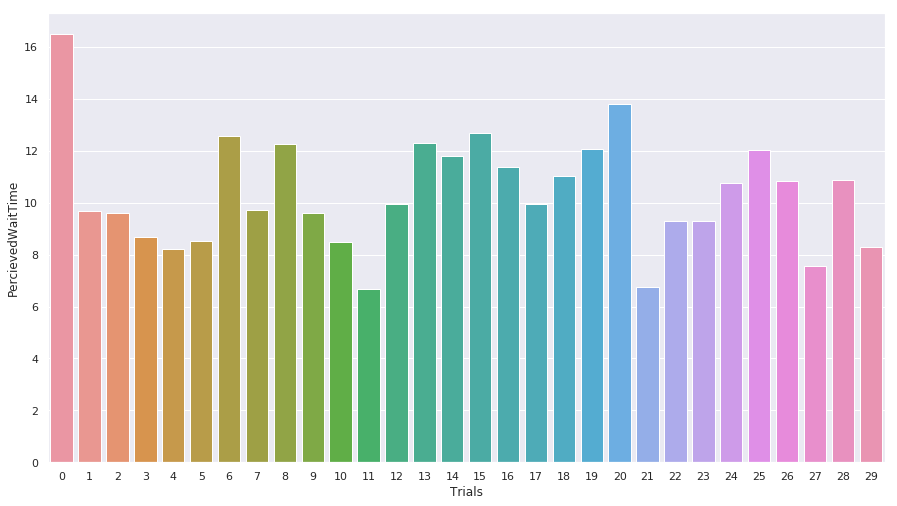

In [139]:
trials = [i for i in range(30)]
df = pd.DataFrame()
df['Trials'] = trials
df['PercievedWaitTime'] = OriginalpercievedWaitTimeTrials
mean_difference = []
print(sum(OriginalpercievedWaitTimeTrials)/len(OriginalpercievedWaitTimeTrials))
average2 = sum(OriginalpercievedWaitTimeTrials)/len(OriginalpercievedWaitTimeTrials)
for data in OriginalpercievedWaitTimeTrials:
    mean_difference.append((data-average2)*(data-average2))
variance2 = sum(mean_difference)/(len(mean_difference)-1)
print(variance2)
print(math.sqrt(variance))


ax = snd.barplot(x="Trials", y="PercievedWaitTime", data=df)

7.805329677184769
3.505377791437909
1.8722654169315602


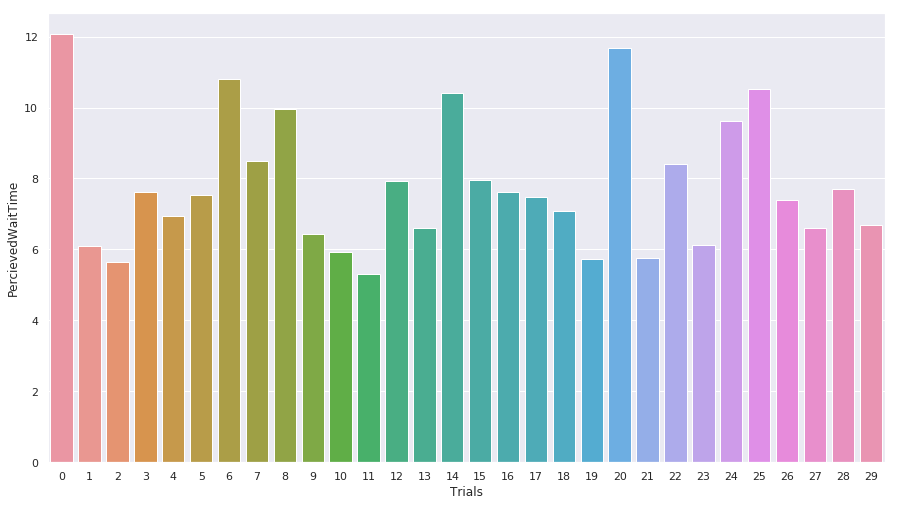

In [140]:
trials = [i for i in range(30)]
df = pd.DataFrame()
df['Trials'] = trials
df['PercievedWaitTime'] = DoublepercievedWaitTimeTrials
print(sum(DoublepercievedWaitTimeTrials)/len(DoublepercievedWaitTimeTrials))
average1 = sum(DoublepercievedWaitTimeTrials)/len(DoublepercievedWaitTimeTrials)
mean_difference = []
for data in DoublepercievedWaitTimeTrials:
    mean_difference.append((data-average1)*(data-average1))
variance1 = sum(mean_difference)/(len(mean_difference)-1)
print(variance1)
print(math.sqrt(variance1))
ax = snd.barplot(x="Trials", y="PercievedWaitTime", data=df)

In [141]:
standard_difference = 0
a = variance1/len(DoublepercievedWaitTimeTrials)
b = variance2/len(DoublepercievedWaitTimeTrials)
standard_difference = math.sqrt(a+b)
print(standard_difference)
print(average1 - average2)

0.5206906436993262
-2.5657904582677915
